# Quantum Evolution with Measurement and  Reset : Method 1


NOTE: Here we have considered wire 0 as signal or feedback qubit, over which we get yi value.

[<img src="https://qbraid-static.s3.amazonaws.com/logos/Launch_on_qBraid_white.png" width="150">](https://account.qbraid.com?gitHubUrl=https://github.com/janhaviC/Quantum-Evolution-with-Measurement-and-Reset/blob/main/Section1/Quantum_Evolution_with_Measurement_and_Reset_Method-1%20.ipynb)

# Initiation

We initiate the environment and load util functions

In [ ]:
! pip install pennylane==0.41.1

In [2]:
import sys
sys.setrecursionlimit(10000)

In [1]:

import datetime
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from functools import partial

dev_q = qml.device("default.qubit", wires=3)




@qml.qnode(dev_q)
def matrix_eval(u, wires):
    u(wires)
    return qml.expval(qml.Identity(0))

def get_list(target_string):
    l = list(target_string)
    return [ int(i) for i in l ]

def calculate_state(base, start, expected):
    if len(expected) == 0:
        return start
    start = base @ start
    if expected[0]:
        amp = sum(start[:4])
        start = np.array(  list(start[4:]) + [0]*4) / amp
    else:
        amp = sum(start[4:])
        start = np.array( list(start[0:4]) + [0]*4 ) / amp
    return calculate_state(base, start, expected[1:])

def convert_to_bin(val, length=5):
    num = bin(val)[2:]
    if len(num) <= length:
        num = "0"*(length-len(num)) + num
    else:
       num = num[0:length]
    return num


def get_max_idx(prob):
  max_val = 0
  max_idx = 0
  for idx, prob_q in enumerate(prob):
    if abs(prob_q) > max_val:
      max_val = abs(prob_q)
      max_idx = idx
  return max_idx, max_val

test_results = []
def compare(base, target_string, probabilities) -> bool:
        global test_results
        len_states = len(base)
        actual_prob = calculate_state(base, np.array([1] + [ 0 ]*( len_states -1 ) ), get_list(target_string))
        print("Expected:", actual_prob)
        ## Get the value with max probability
        max_qx = 0
        max_val = 0
        for qc, qq in enumerate(actual_prob):
            if qq < 0:
                qq = qq * -1
            if max_val < qq :
                max_val = qq
                max_qx = qc
        ## Getting q1, q2 related to the state that has max probablity
        max_qx = convert_to_bin(max_qx, 3)
        calculated_probabilities = []
        for qx, prob in enumerate(probabilities):
            qp_sum = [0]
            idx, val = get_max_idx(prob)
            val_q = convert_to_bin(idx, 4)[0:3]
            if val_q == max_qx:
                calculated_probabilities.append(val > 0.9)
                print(f"Probability of the expected state in the simulated result: {val}")
        test_results.append((len(target_string), actual_prob, probabilities))
        return all(calculated_probabilities) and calculated_probabilities

def get_simulated_state_vectors(unitary, target_string):
    return [ evolution_measurement_and_reset(unitary, target_string) ]



def amplitude_damping_unitary_stinespring(gamma):
    U_matrix = np.array([
        [1, 0, 0, 0],                            # |00> -> |00>
        [0, np.sqrt(1 - gamma), np.sqrt(gamma), 0], # |10> -> sqrt(1-g)|10> + sqrt(g)|01>
        [0, -np.sqrt(gamma), np.sqrt(1 - gamma), 0], # |01> -> -sqrt(g)|10> + sqrt(1-g)|01>
        [0, 0, 0, 1]                             # |11> -> |11>
    ])
    return U_matrix

def get_probability(target_string):
  probability =0
  if target_string =="1":
    probability =1
  return probability

# Test Script

Defined different U operations and use them for testing.

In [2]:
def u_1(wires):
  qml.X(wires=wires[1])
  qml.X(wires=wires[0])
  qml.H(wires=wires[0])
  qml.CNOT(wires=[wires[0], wires[2]])
  qml.CNOT(wires=[wires[2], wires[1]])

def u_2(wires):
  qml.Hadamard(wires[0])
  qml.H(wires=2)
  qml.CNOT(wires=wires[0:2])
  qml.X(wires=2)
  qml.H(wires=2)
  qml.CNOT(wires=[wires[1], wires[2]])

def u_3(wires):
  qml.X(wires=1)
  qml.X(wires=0)
  qml.Hadamard(wires[0])
  qml.CNOT(wires=wires[0:2])
  qml.CNOT(wires=[wires[0], wires[2]])

def u_4(wires):
  qml.X(wires=1)
  qml.X(wires=0)
  qml.CNOT(wires=[wires[1], wires[2]])
  qml.Hadamard(wires[0])
  qml.CNOT(wires=wires[0:2])
  qml.CNOT(wires=[wires[0], wires[2]])

def u_5(wires):
  qml.Hadamard(wires[0])
  qml.CNOT(wires=wires[0:2])
  qml.X(wires=2)
  qml.CNOT(wires=[wires[0], wires[2]])
  qml.CNOT(wires=[wires[2], wires[1]])
  qml.CNOT(wires=[wires[1], wires[0]])

def u_6(wires):
  qml.X(wires=wires[1])
  qml.X(wires=wires[0])
  qml.H(wires=wires[0])
  qml.CZ(wires=[wires[0], wires[1]])
  qml.CNOT(wires=[wires[0], wires[2]])
  qml.CNOT(wires=[wires[2], wires[1]])


def u_7(wires):
  qml.H(wires=wires[1])
  qml.CZ(wires=[wires[1], wires[2]])
  qml.H(wires=wires[0])
  qml.H(wires=wires[1])
  qml.CZ(wires=[wires[0], wires[1]])
  qml.CNOT(wires=[wires[0], wires[2]])
  qml.CNOT(wires=[wires[2], wires[1]])

registered_tests = [ u_1, u_2, u_3, u_4, u_5, u_6, u_7 ]

multi_tests = {}
def test(unitary, target_string, debug=0, offset=0, iterate=1):
  state_vector = qml.matrix(matrix_eval)(unitary, range(3))
  for target in range(offset, len(target_string), iterate):
      if debug: print(f"Running tests for n = {target}")
      t1 = datetime.datetime.now()
      assert compare(state_vector, target_string[:target+1], get_simulated_state_vectors(unitary, target_string[:target+1])),\
        f"Error with execution of target string {target_string[:target+1]}"
      if debug: print(f"Took { datetime.datetime.now() - t1 } time to execute for {target_string[:target+1]}")
  print("All test cases passed")


def run_tests(target_string, debug=0, offset=0, iterate=1, num_of_tests=-1):
  """
  args:
    - debug: bool: default to 0, set it to 1 to get run details
    - offset: int: Set the offset for the target string
    - iterate: int: What should be the iterator value, current set to 1
    - num_of_tests: int: -1 if we want to run all registered tests
  """
  global test_results, multi_tests
  if num_of_tests == -1:
    num_of_tests = len(registered_tests)
  for func in registered_tests[:num_of_tests]:
    print(f"Running test for {func.__name__}")
    test_results = []
    test(func, target_string, debug=debug, offset=offset, iterate=iterate)
    multi_tests[func.__name__] = test_results


In [3]:
num_wires = 4
num_qubits = 4

simulator_type = "default.mixed"
dev_q = qml.device(simulator_type, wires=num_wires)
dev = qml.device(simulator_type, wires=num_wires, shots=1024)

# Logic

We apply U followed by amplify and reset block (ARB). Main function is evolution_measurement_and_reset which call in the U and ARB block. We pass in the U operator and the target string which we need to simulate without measurement.

In [4]:

# --- 2. Oracle (U_omega = S_f) ---
def phase_oracle(wires, target_string):
    """
    Oracle to mark the target_string with a phase flip for 1 qubit.
    This is S_f = I - 2|target><target|.
    """
    if target_string == '0':
        qml.PauliX(wires=wires[0])
    qml.PauliZ(wires=wires[0])
    if target_string == '0':
        qml.PauliX(wires=wires[0])

# --- 3. Reflection about the Initial State (S_A = A S_0 A_dagger) Diffusion---
def reflect_about_initial_state(wires, unitary, diffusion_wires):
    """
    Implements the reflection S_A = I - 2|A><A| = A (I - 2|0...0><0...0|) A_dagger.
    This is A @ S_0 @ A_dagger.
    """
    # Apply A_dagger (inverse of initial_state_preparation)

    qml.adjoint(unitary)(wires)
    n_qubits = len(diffusion_wires)
    for wire in diffusion_wires:
        qml.PauliX(wires=wire)
    if n_qubits == 1:
        qml.PauliZ(wires=diffusion_wires[0])
    elif n_qubits == 2:
        qml.CZ(wires=[diffusion_wires[0], diffusion_wires[-1]])
    else:
        qml.H(wires=diffusion_wires[-1])
        qml.MultiControlledX(diffusion_wires=[0,3])
        qml.H(wires=diffusion_wires[-1])
    for wire in diffusion_wires:
        qml.PauliX(wires=wire)
    unitary(wires)


def set_auxilary(target_string, damp_wires):
    if target_string == "0":
        qml.X(wires=3)
    qml.CNOT(wires=damp_wires)

def apply_and_mix_amp(target_string, unitary, damp_wires):
    unitary(range(num_qubits))
    qml.Barrier()
    set_auxilary(target_string, damp_wires)
    qml.Barrier()
    #U_stinespring = amplitude_damping_unitary_stinespring(get_probability(target_string))
    #qml.QubitUnitary(U_stinespring, wires=damp_wires)

# --- Generalized Amplitude Amplification Circuit (Q = S_A S_f) ---
@qml.qnode(dev)
def evolution_measurement_and_reset(unitary, target_string):
    n_qubits = num_qubits
    target_wires = [0, 3]
    for i in target_string:
        apply_and_mix_amp(i, unitary, target_wires)
        phase_oracle(range(0,num_qubits), i)

        qml.Barrier()
        reflect_about_initial_state(range(n_qubits), unitary, target_wires)
        qml.Barrier()
        qml.H(wires=[3])
        if i == "0":
          qml.X(wires=[0])
        qml.Z(wires=[0])
        if i == "0":
          qml.X(wires=[0])
        if i == "1":
          qml.X(wires=[0]) ## Reset to 0
    return qml.probs(wires=range(n_qubits)) # Return probabilities


# Run Test

In [5]:
target_string = "000110010101111001001011011000000100010011010111101100001111101011010001111000100011111010100010100000011011111111101000111010011111101000011010111010010110111100111110000000000001001000111011110001110000100110011001010101001101110111100100011101111111110111110010010000101101011100111111010101110000001111110010110011111100100000110011111100001100010100000001101011111000101100100110110011100001101111011110011011100000111000000000100110010011011010000000010001110100011111110010101000110100110110100000010001101111011010001101010111100110011011110001001000101111010011010100111111101100110111110001111101001100110000111010001111100011010001000000101010010110011010101000000101000100010011101000100001100011001011011001011010111001011100001111000000010100011101011010101000110011111011110011111001010010110001011010001011010000101101110001110101100111000000100000001001011100111001011110001110110011110101110010110010001110100111100001011101101000110110111101011010101010000000101010111110110001000011101010110001011011001110001000001101111011011101011010001110001110011110011010111101011001011100010100001111010010101101101010000000101000000000110101100110111110000010100010011110111101011111100011111001101001000100110001001011001000010001000011110111011100000011110010111100000010101100000001001011000010001100000101010001010101011010110000011001000011101001111011001110100011001101100101111100100110010100101101101000010111101111111001100100010011110111001110100000001001011011111111011110100111010011011001110001001100100000101110100000110010101100111101001001000111111111011101010001110010101011001001001000000110000100110010100000101011111101010100111111110001011011000101010101111100100111001001001010011111010000011110010100110111110111001100111110100010011001111000001001110001010100000001010111101100110110001011001110001010100010100011100100101011110011001111110011101001100101011010011100011101100111100111111110001000100001100101111101111011011010101011111111011010000011010101000010110"
## Length of the string is 2001

print(f"Len of the target string is {len(target_string)}")

Len of the target string is 2001


## Create target string [ optional ]

In [ ]:
import random


def create_target_string(size, seed=None) -> str:
  target_string = ""
  if seed:
    random.seed(seed)
  for i in range(size):
    target_string = target_string + random.choice(["1", "0"])
  return target_string


target_string = create_target_string(10)

0101010001


## Execute

In [6]:
## While running tests we also validate the result

run_tests(target_string[:10], debug=True, offset=0, iterate=1)

Running test for u_1
Running tests for n = 0
Expected: [-0. -0. -1. -0. -0. -0. -0. -0.]
Probability of the expected state in the simulated result: 1.0
Took 0:00:00.016540 time to execute for 0
Running tests for n = 1
Expected: [-1.  0.  0.  0.  0.  0.  0.  0.]
Probability of the expected state in the simulated result: 1.0
Took 0:00:00.027955 time to execute for 00
Running tests for n = 2
Expected: [ 0.  0. -1.  0.  0.  0.  0.  0.]
Probability of the expected state in the simulated result: 1.0
Took 0:00:00.043033 time to execute for 000
Running tests for n = 3
Expected: [-0. -0. -0. -1. -0. -0. -0. -0.]
Probability of the expected state in the simulated result: 1.0
Took 0:00:00.032694 time to execute for 0001
Running tests for n = 4
Expected: [-1. -0. -0. -0. -0. -0. -0. -0.]
Probability of the expected state in the simulated result: 1.0
Took 0:00:00.035351 time to execute for 00011
Running tests for n = 5
Expected: [ 0.  0. -1.  0.  0.  0.  0.  0.]
Probability of the expected state in

# Visulaization [Optional]

In [ ]:
! pip install scipy

In [8]:
from scipy.stats import wasserstein_distance # For Earth Mover's Distance
from scipy.special import rel_entr # For KL Divergence (relative entropy)
import matplotlib.pyplot as plt
import numpy as np


def format_prob(prob_dist2_ori):
  prob_dist2 = []
  for i, val in enumerate(prob_dist2_ori):
    if (i + 1) % 2 != 0:
      prob_dist2.append(val)
    else:
      prob_dist2[-1] = prob_dist2[-1] + val
  return prob_dist2

def normalize_array(ar):
  for i in range(len(ar)):
    ar[i] = abs(ar[i])

def calculate_probabilistic_fidelity(prob_dist1, prob_dist2):
    """Calculates fidelity between two probability distributions."""
    # Ensure non-negative and normalized
    prob_dist1 = prob_dist1 / np.sum(prob_dist1)
    prob_dist2 = prob_dist2 / np.sum(prob_dist2)

    fidelity = np.sum(np.sqrt(prob_dist1 * prob_dist2))**2
    return fidelity

def calculate_kl_divergence(p_dist, q_dist, epsilon=1e-20):
    """Calculates KL Divergence D_KL(P || Q), adding epsilon to avoid log(0)."""
    p_dist = np.array(p_dist) + epsilon
    q_dist = np.array(q_dist) + epsilon
    # Normalize after adding epsilon just to be safe
    p_dist = p_dist / np.sum(p_dist)
    q_dist = q_dist / np.sum(q_dist)

    kl_div = np.sum(rel_entr(p_dist, q_dist))
    return kl_div



def plot_multi_series(x_data, series_y_data, series_labels, chart_title,
                      x_label='X-Axis Value', y_label='Y-Axis Value',
                      line_styles=None, marker_styles=None, colors=None,
                      figsize=(10, 6)):
    """
    Creates a 2D graph with multiple data series.

    Args:
        x_data (array-like): The common x-axis data for all series.
        series_y_data (list of array-like): A list where each element is the
                                            y-data for one series.
        series_labels (list of str): A list of labels for each series,
                                     used in the legend.
        chart_title (str): The main title for the chart.
        x_label (str, optional): Label for the x-axis. Defaults to 'X-Axis Value'.
        y_label (str, optional): Label for the y-axis. Defaults to 'Y-Axis Value'.
        line_styles (list of str, optional): List of matplotlib line styles (e.g., '-', '--', ':').
                                            If not provided, default styles will cycle.
        marker_styles (list of str, optional): List of matplotlib marker styles (e.g., 'o', 'x', '^').
                                              If not provided, no markers are used by default.
        colors (list of str, optional): List of matplotlib color names or hex codes.
                                        If not provided, default colors will cycle.
        figsize (tuple, optional): A tuple (width, height) in inches for the figure size.
                                   Defaults to (10, 6).

    Raises:
        ValueError: If the number of y-data series doesn't match the number of labels.
    """

    if len(series_y_data) != len(series_labels):
        raise ValueError("Oops! The number of data series doesn't match the number of labels. "
                         "Every series needs a name, just like every pet needs a good cuddle!")

    plt.figure(figsize=figsize)

    # Define some default styles if not provided, to keep things looking good
    default_colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']
    default_line_styles = ['-', '--', ':', '-.']
    default_marker_styles = ['o', 'x', '^', 's', 'D', 'p', '*'] # Circle, x, triangle up, square, diamond, pentagon, star

    for i, y_data in enumerate(series_y_data):
        label = series_labels[i]

        # Cycle through provided or default styles
        color = colors[i % len(colors)] if colors else default_colors[i % len(default_colors)]
        line_style = line_styles[i % len(line_styles)] if line_styles else default_line_styles[i % len(default_line_styles)]
        marker_style = marker_styles[i % len(marker_styles)] if marker_styles else None # Default to no marker

        plt.plot(x_data, y_data, label=label, color=color,
                 linestyle=line_style, marker=marker_style, markersize=5 if marker_style else 0)

    # Set the titles, labels, and legend
    plt.title(chart_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7) # A nice grid makes everything clearer!

    plt.show()


def get_results(results):
  fidelity = []
  kl = []
  x = []

  for result in results:
    data = [result[0], result[1].tolist(), format_prob(result[2][0].tolist())]
    normalize_array(data[1])
    fidelity.append(calculate_probabilistic_fidelity(data[1], data[2]))
    kl.append(calculate_kl_divergence(data[1], data[2]))
    x.append(result[0])
  return x, fidelity, kl

### To display for single run type
def display_results(results):
  x, fidelity, kl = get_results(results)
  plot_multi_series(x, [fidelity], ["1024 shots"], "Fidelity", x_label="Number of U", y_label="Fidelity")
  plot_multi_series(x, [kl], ["1024 shots"], "KL", x_label="Number of U", y_label="KL")


def display_results_multi(results):
  fidelity = []
  kl = []
  x = []
  index = []
  for key, value in results.items():
    index.append(key)
    x1, fidelity1, kl1 = get_results(value)
    x.append(x1)
    fidelity.append(fidelity1)
    kl.append(kl1)
  plot_multi_series(x[0], fidelity, index, "Fidelity", x_label="Number of U", y_label="Fidelity")
  plot_multi_series(x[0], kl, index, "KL", x_label="Number of U", y_label="KL")


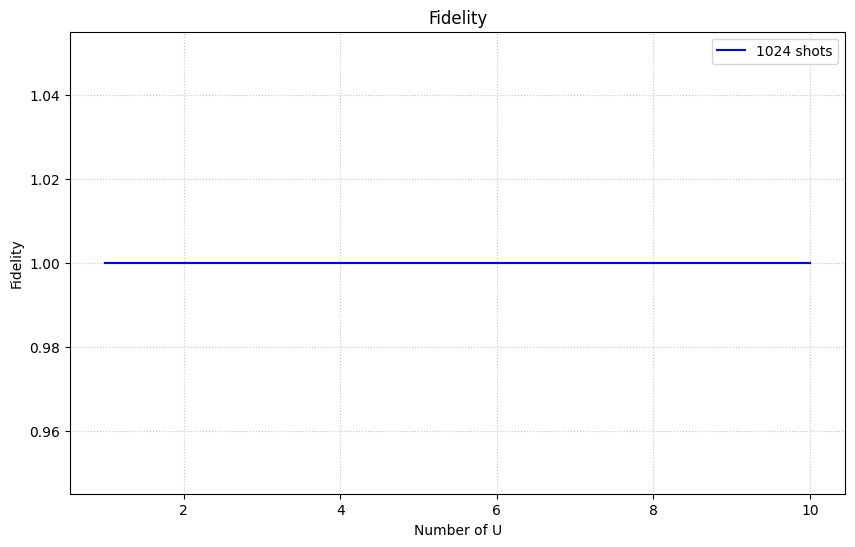

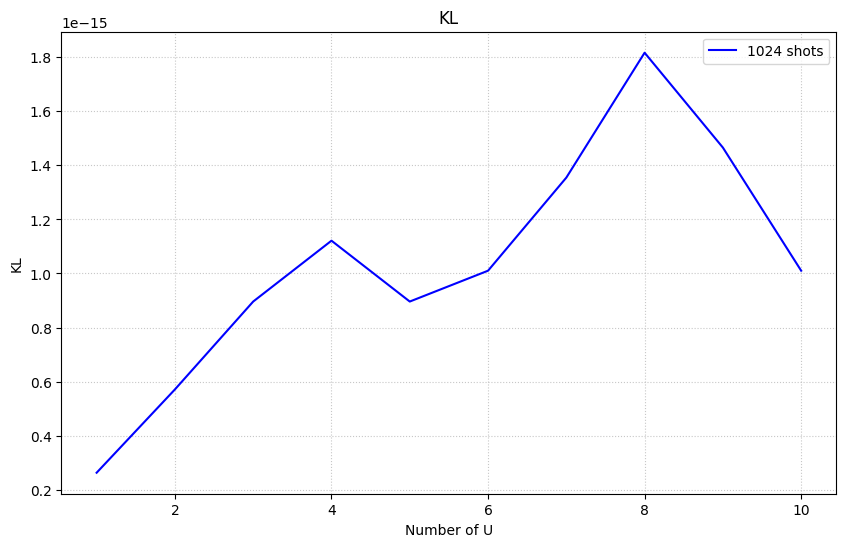

In [9]:
display_results(test_results)

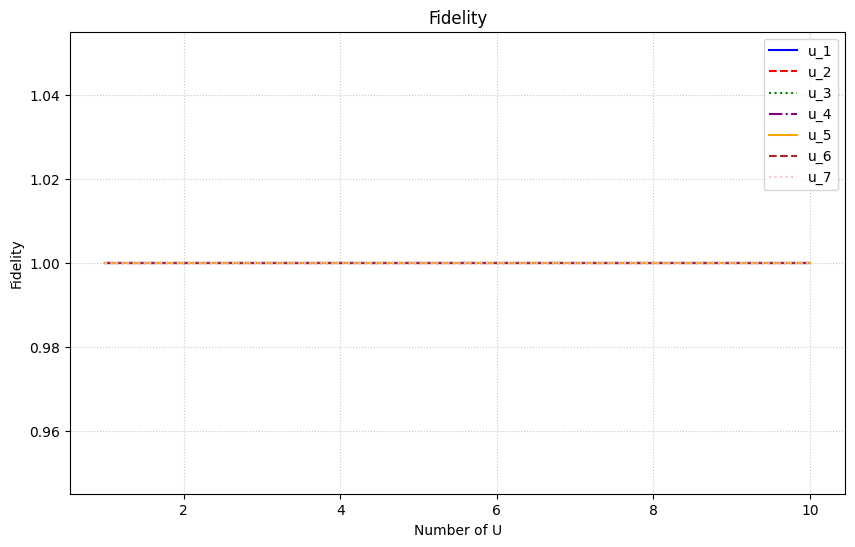

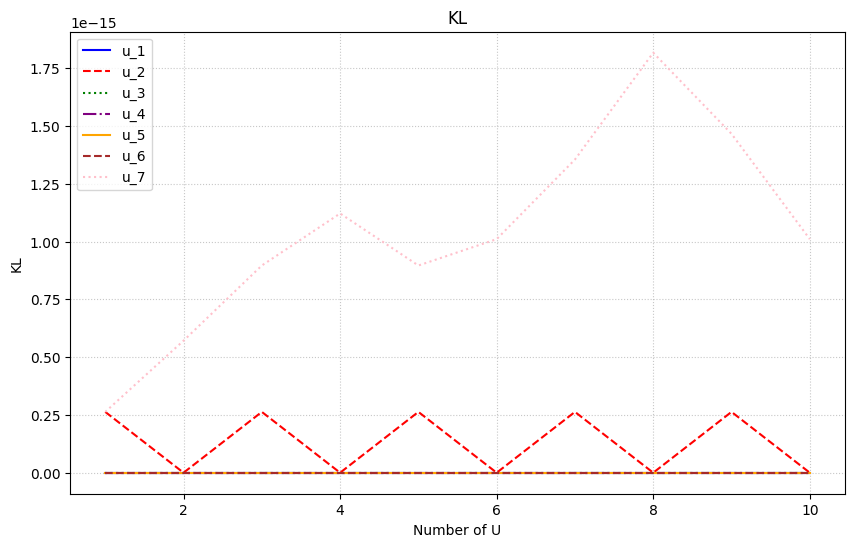

In [10]:
display_results_multi(multi_tests)